<a href="https://colab.research.google.com/github/Madhuvod/AI-Rover/blob/main/music_recs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

In [2]:
#used synthetic data instead of real data
np.random.seed(42)
num_users = 1000
num_songs = 5000
num_interactions = 50000

user_ids = np.random.randint(0, num_users, num_interactions)
song_ids = np.random.randint(0, num_songs, num_interactions)
user_song_data = pd.DataFrame({'user_id': user_ids, 'song_id': song_ids})
user_song_data = user_song_data.drop_duplicates()

print(user_song_data.head())
print(f"Number of unique users: {user_song_data['user_id'].nunique()}")
print(f"Number of unique songs: {user_song_data['song_id'].nunique()}")

   user_id  song_id
0      102     3456
1      435     1882
2      860     2275
3      270     2621
4      106      600
Number of unique users: 1000
Number of unique songs: 5000


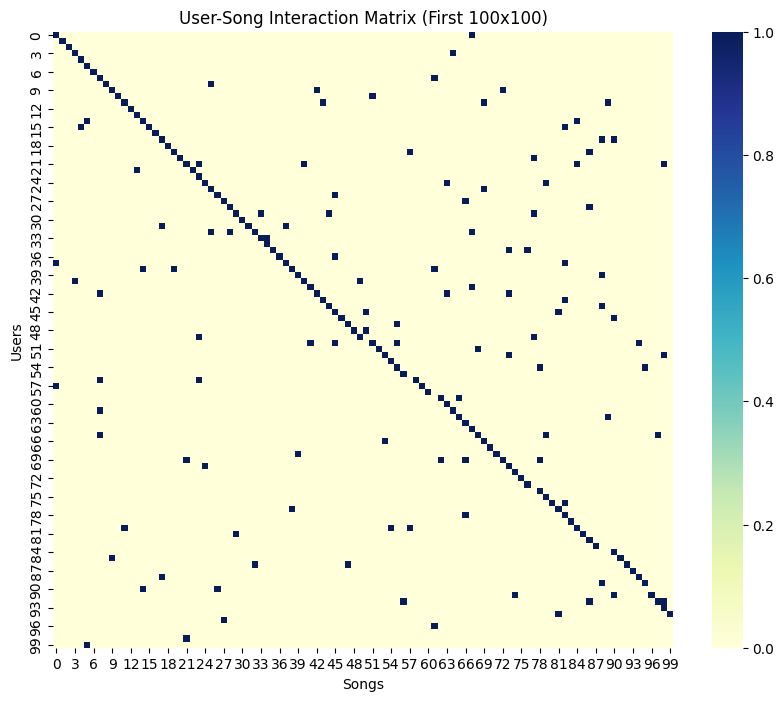

Matrix shape: (1000, 5000)
Sparsity: 0.9900


In [3]:
user_ids = user_song_data['user_id'].unique()
song_ids = user_song_data['song_id'].unique()
num_users = len(user_ids)
num_songs = len(song_ids)

user_encoder = {user_id: i for i, user_id in enumerate(user_ids)}
song_encoder = {song_id: i for i, song_id in enumerate(song_ids)}

user_song_matrix = np.zeros((num_users, num_songs))
for _, row in user_song_data.iterrows():
    user_id = row['user_id']
    song_id = row['song_id']
    user_song_matrix[user_encoder[user_id], song_encoder[song_id]] = 1

# Visualize the sparsity of the user-song matrix
plt.figure(figsize=(10, 8))
sns.heatmap(user_song_matrix[:100, :100], cmap='YlGnBu')
plt.title('User-Song Interaction Matrix (First 100x100)')
plt.xlabel('Songs')
plt.ylabel('Users')
plt.show()

print(f"Matrix shape: {user_song_matrix.shape}")
print(f"Sparsity: {1 - np.count_nonzero(user_song_matrix) / user_song_matrix.size:.4f}")

In [4]:
# Cell 4: Define the dataset and model
class MusicDataset(Dataset):
    def __init__(self, user_song_matrix):
        self.user_song_matrix = user_song_matrix

    def __len__(self):
        return self.user_song_matrix.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.user_song_matrix[idx]).float()

class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, int(hidden_size/2)),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(int(hidden_size/2), hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Split the data into train and test sets
train_data, test_data = train_test_split(user_song_matrix, test_size=0.2, random_state=42)

# Create the datasets and dataloaders
train_dataset = MusicDataset(train_data)
test_dataset = MusicDataset(test_data)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Initialize the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoEncoder(num_songs, 128).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch [10/50], Train Loss: 0.0925, Test Loss: 0.0874
Epoch [20/50], Train Loss: 0.0570, Test Loss: 0.0594
Epoch [30/50], Train Loss: 0.0562, Test Loss: 0.0595
Epoch [40/50], Train Loss: 0.0557, Test Loss: 0.0597
Epoch [50/50], Train Loss: 0.0558, Test Loss: 0.0599


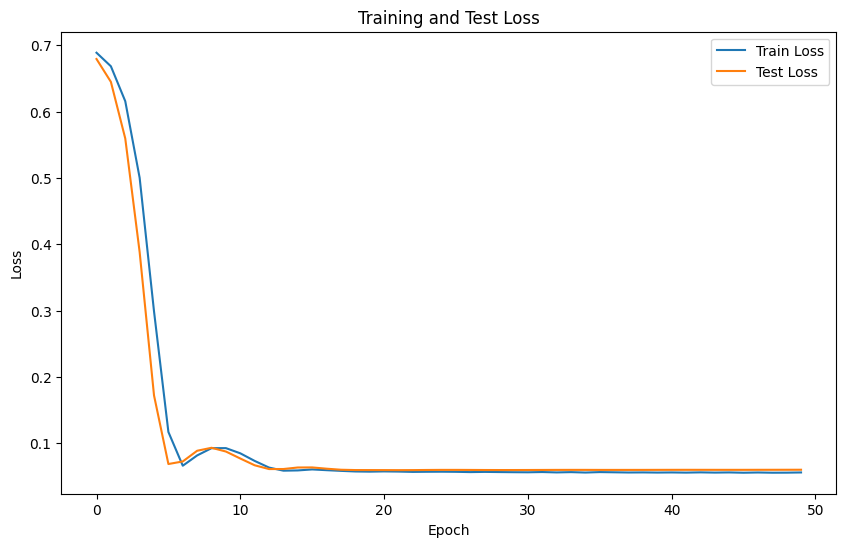

In [5]:
# Cell 5: Train the model
num_epochs = 50
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for data in train_dataloader:
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_dataloader))

    model.eval()
    with torch.no_grad():
        test_loss = sum(criterion(model(data.to(device)), data.to(device)).item()
                        for data in test_dataloader) / len(test_dataloader)
    test_losses.append(test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

# Plot the training and test losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0000
Recall: 0.0000


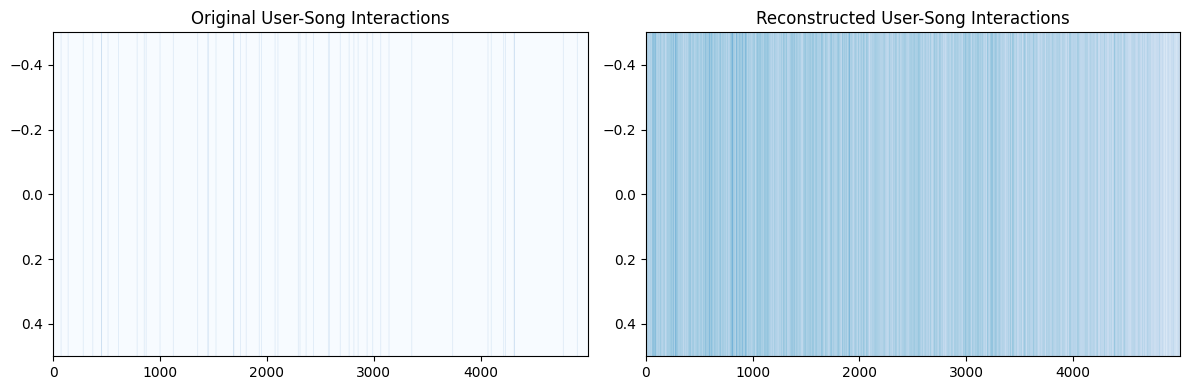

In [6]:
# Cell 6: Evaluate the model
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for data in test_dataloader:
        data = data.to(device)
        outputs = model(data)
        predictions = (outputs > 0.5).float()
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(data.cpu().numpy())

all_predictions = np.concatenate(all_predictions)
all_targets = np.concatenate(all_targets)

precision = precision_score(all_targets.flatten(), all_predictions.flatten())
recall = recall_score(all_targets.flatten(), all_predictions.flatten())

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Visualize the reconstruction of a random user's listening history
random_user = np.random.randint(0, len(test_dataset))
user_data = test_dataset[random_user].unsqueeze(0).to(device)
reconstructed = model(user_data).squeeze().cpu().detach().numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(user_data.cpu().numpy().reshape(1, -1), cmap='Blues', aspect='auto')
plt.title('Original User-Song Interactions')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed.reshape(1, -1), cmap='Blues', aspect='auto')
plt.title('Reconstructed User-Song Interactions')
plt.tight_layout()
plt.show()

Top 10 recommendations for user 235:
1. Song 3256
2. Song 1023
3. Song 4839
4. Song 4482
5. Song 2991
6. Song 1567
7. Song 3674
8. Song 2367
9. Song 3331
10. Song 2857


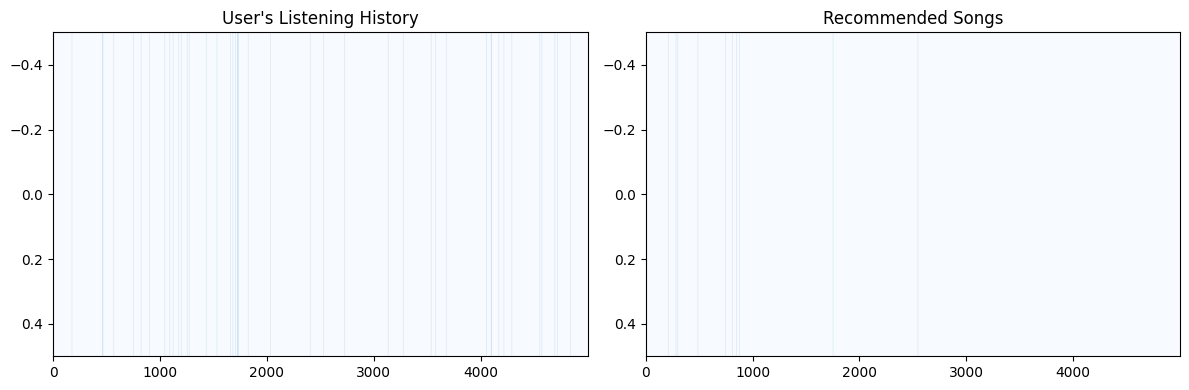

In [7]:
# Cell 7: Generate recommendations
def get_recommendations(user_id, top_k=10):
    user_vector = torch.from_numpy(user_song_matrix[user_encoder[user_id]]).float().unsqueeze(0).to(device)
    with torch.no_grad():
        reconstructed = model(user_vector).squeeze().cpu().numpy()

    # Get the indices of the top-k recommended songs
    listened_songs = set(np.where(user_vector.squeeze().cpu().numpy() > 0)[0])
    unlistened_songs = set(range(num_songs)) - listened_songs
    recommendations = sorted(unlistened_songs, key=lambda x: reconstructed[x], reverse=True)[:top_k]

    return recommendations

# Generate recommendations for a random user
random_user = np.random.choice(user_ids)
recommendations = get_recommendations(random_user)

print(f"Top 10 recommendations for user {random_user}:")
for i, song_id in enumerate(recommendations, 1):
    print(f"{i}. Song {song_ids[song_id]}")

# Visualize the user's listening history and recommendations
user_history = user_song_matrix[user_encoder[random_user]]
recommended_songs = np.zeros_like(user_history)
recommended_songs[recommendations] = 1

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(user_history.reshape(1, -1), cmap='Blues', aspect='auto')
plt.title("User's Listening History")
plt.subplot(1, 2, 2)
plt.imshow(recommended_songs.reshape(1, -1), cmap='Blues', aspect='auto')
plt.title('Recommended Songs')
plt.tight_layout()
plt.show()